# R2 - Model Selection and Backbone Analysis for Image Similarity Assessment Task

This notebook explores and analyzes various pretrained model architectures available in the `timm` library to select the most suitable backbone for our image similarity assessment models. We'll evaluate models based on size, accuracy, and other relevant metrics to make an informed selection.

## Project Overview

Building on insights from our data exploration notebook, we need to select an appropriate backbone model for our image similarity assessment models. The backbone should:

- Balance performance and computational efficiency
- Have strong feature extraction capabilities for flower image characteristics
- Support our similarity learning task through transferable features

We'll analyze benchmark data from timm models to identify candidates that meet these criteria.

## Section 1: Load Model Benchmark Data

First, we'll load the ImageNet benchmark data from the timm repository. This data contains performance metrics for various model architectures.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timm
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
!wget https://raw.githubusercontent.com/huggingface/pytorch-image-models/v1.0.9/results/results-imagenet.csv

--2025-07-18 22:02:25--  https://raw.githubusercontent.com/huggingface/pytorch-image-models/v1.0.9/results/results-imagenet.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113785 (111K) [text/plain]
Saving to: ‘results-imagenet.csv’

results-imagenet.cs 100%[===================>] 111.12K  --.-KB/s    in 0.02s   

2025-07-18 22:02:25 (4.53 MB/s) - ‘results-imagenet.csv’ saved [113785/113785]



In [3]:
# Load the ImageNet benchmark results
benchmark_path = Path('results-imagenet.csv')
benchmark = pd.read_csv(benchmark_path)

# Display the first few rows to understand the data structure
benchmark.head()

,model,img_size,top1,top1_err,top5,top5_err,param_count,crop_pct,interpolation
0,eva02_large_patch14_448.mim_m38m_ft_in22k_in1k,448,90.054,9.946,99.056,0.944,305.08,1.0,bicubic
1,eva02_large_patch14_448.mim_in22k_ft_in22k_in1k,448,89.966,10.034,99.016,0.984,305.08,1.0,bicubic
2,eva_giant_patch14_560.m30m_ft_in22k_in1k,560,89.796,10.204,98.990,1.010,"1,014.45",1.0,bicubic
3,eva02_large_patch14_448.mim_in22k_ft_in1k,448,89.632,10.368,98.954,1.046,305.08,1.0,bicubic
4,eva_giant_patch14_336.m30m_ft_in22k_in1k,336,89.570,10.430,98.954,1.046,"1,013.01",1.0,bicubic


In [4]:
# Check the dimensions of the benchmark dataset
print(f"Total number of models in the benchmark: {benchmark.shape[0]}")
print(f"Number of metrics per model: {benchmark.shape[1]}")

# Overview of available columns
print("\nAvailable metrics:")
for col in benchmark.columns:
    print(f"- {col}")

Total number of models in the benchmark: 1445
Number of metrics per model: 9

Available metrics:
- model
- img_size
- top1
- top1_err
- top5
- top5_err
- param_count
- crop_pct
- interpolation


## Section 2: Parse and Clean Model Metadata

Now we'll parse the model names to extract architecture information and clean the data for analysis.

In [5]:
# Create mapping between models and modules
model_module_map = {}
for module in timm.list_modules():
    for model in timm.list_models(module=module):
        model_module_map[model] = module

# Function to extract dataset information from model name
def extract_datasets(model_name):
    parts = model_name.split(".")
    datasets = parts[1].split("_") if len(parts) > 1 else []
    return tuple(datasets)

# Add architecture and module information
benchmark["architecture"] = benchmark["model"].apply(lambda x: x.split(".")[0])
benchmark["datasets"] = benchmark["model"].apply(extract_datasets)

# Add module information where available
def get_module(arch):
    try:
        return model_module_map.get(arch, "unknown")
    except:
        return "unknown"

benchmark["module"] = benchmark["architecture"].apply(get_module)

# Convert parameter count to numeric
benchmark["param_count_numeric"] = benchmark["param_count"].apply(
    lambda x: float(str(x).replace(",", "")) if isinstance(x, (str, int, float)) else np.nan
)

# Display updated benchmark
benchmark.head()

,model,img_size,top1,top1_err,top5,top5_err,param_count,crop_pct,interpolation,architecture,datasets,module,param_count_numeric
0,eva02_large_patch14_448.mim_m38m_ft_in22k_in1k,448,90.054,9.946,99.056,0.944,305.08,1.0,bicubic,eva02_large_patch14_448,"(mim, m38m, ft, in22k, in1k)",eva,305.08
1,eva02_large_patch14_448.mim_in22k_ft_in22k_in1k,448,89.966,10.034,99.016,0.984,305.08,1.0,bicubic,eva02_large_patch14_448,"(mim, in22k, ft, in22k, in1k)",eva,305.08
2,eva_giant_patch14_560.m30m_ft_in22k_in1k,560,89.796,10.204,98.990,1.010,"1,014.45",1.0,bicubic,eva_giant_patch14_560,"(m30m, ft, in22k, in1k)",eva,1014.45
3,eva02_large_patch14_448.mim_in22k_ft_in1k,448,89.632,10.368,98.954,1.046,305.08,1.0,bicubic,eva02_large_patch14_448,"(mim, in22k, ft, in1k)",eva,305.08
4,eva_giant_patch14_336.m30m_ft_in22k_in1k,336,89.570,10.430,98.954,1.046,"1,013.01",1.0,bicubic,eva_giant_patch14_336,"(m30m, ft, in22k, in1k)",eva,1013.01


In [6]:
# Filter models to focus on the most relevant ones for our task

# Define acceptable dataset combinations (focusing on ImageNet trained models)
acceptable_datasets = [
    ('in1k',),           # ImageNet-1K
    ('tv', 'in1k'),      # Timm variant + ImageNet-1K
    ('tv2', 'in1k'),     # Timm variant 2 + ImageNet-1K
    ('tf', 'in1k'),      # TensorFlow trained + ImageNet-1K
]

# Filter out distilled models and keep only those trained on acceptable datasets
filtered_benchmark = benchmark[
    benchmark["datasets"].apply(lambda x: x in acceptable_datasets) &
    benchmark["model"].apply(lambda x: "distilled" not in x)
]

print(f"Original benchmark size: {len(benchmark)}")
print(f"Filtered benchmark size: {len(filtered_benchmark)}")

Original benchmark size: 1445
Filtered benchmark size: 243


In [7]:
# Further filter by standard image size (224x224) for fair comparison
benchmark_224 = filtered_benchmark[filtered_benchmark["img_size"] == 224].reset_index(drop=True)
print(f"Number of models with 224x224 image size: {len(benchmark_224)}")

benchmark_224.head()

Number of models with 224x224 image size: 152


,model,img_size,top1,top1_err,top5,top5_err,param_count,crop_pct,interpolation,architecture,datasets,module,param_count_numeric
0,maxvit_large_tf_224.in1k,224,84.934,15.066,96.980,3.020,211.79,0.950,bicubic,maxvit_large_tf_224,"(in1k,)",maxxvit,211.79
1,maxvit_base_tf_224.in1k,224,84.870,15.130,97.004,2.996,119.47,0.950,bicubic,maxvit_base_tf_224,"(in1k,)",maxxvit,119.47
2,maxvit_small_tf_224.in1k,224,84.456,15.544,96.828,3.172,68.93,0.950,bicubic,maxvit_small_tf_224,"(in1k,)",maxxvit,68.93
3,gcvit_base.in1k,224,84.454,15.546,96.850,3.150,90.32,0.875,bicubic,gcvit_base,"(in1k,)",gcvit,90.32
4,gcvit_small.in1k,224,83.908,16.092,96.660,3.340,51.09,0.875,bicubic,gcvit_small,"(in1k,)",gcvit,51.09


## Section 3: Explore Model Architectures and Families

Let's analyze the different architecture families in the benchmark and their representation.

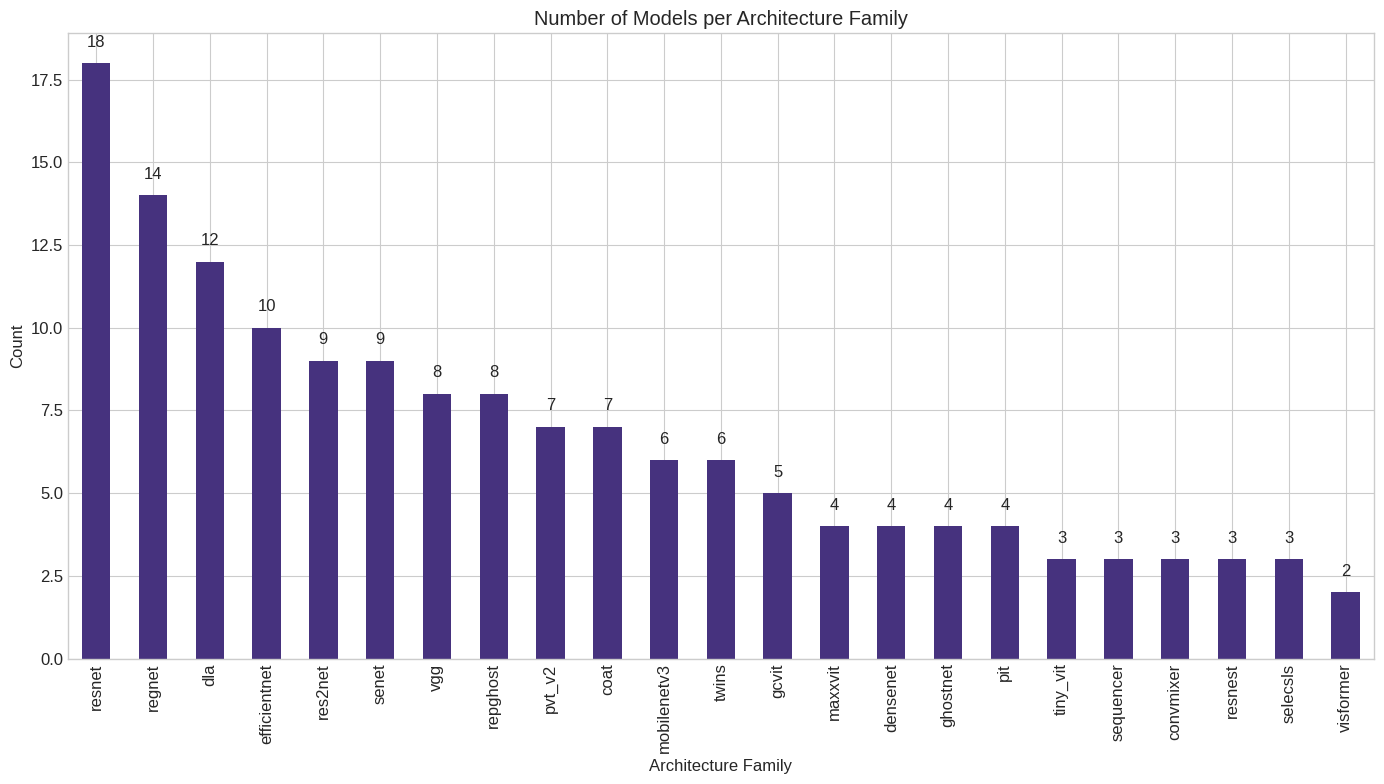

In [8]:
# Count models per module/family
module_counts = benchmark_224["module"].value_counts()

# Plot the module distribution
plt.figure(figsize=(14, 8))
ax = module_counts.plot(kind='bar')
plt.title('Number of Models per Architecture Family')
plt.xlabel('Architecture Family')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Add count labels on top of bars
for i, v in enumerate(module_counts):
    ax.text(i, v + 0.5, str(v), ha='center')

plt.tight_layout()
plt.show()

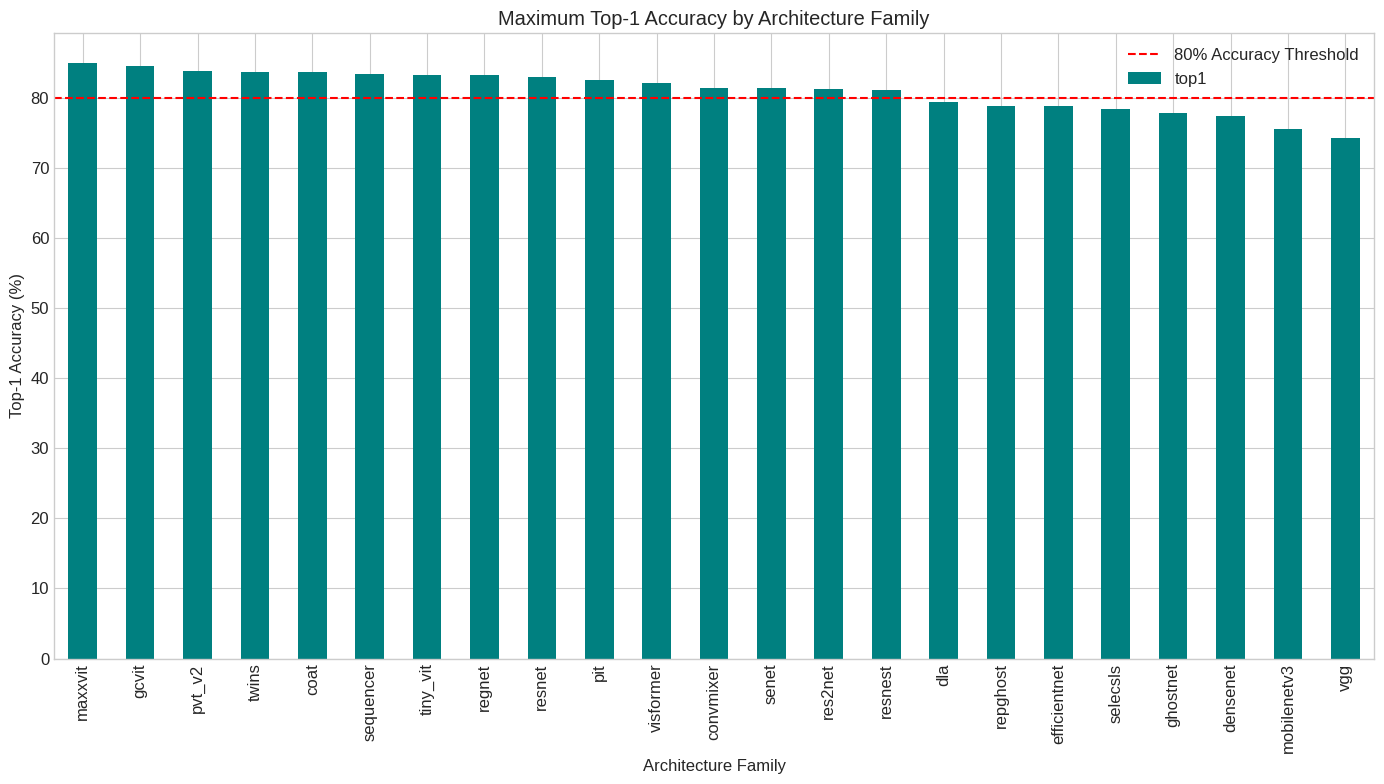

module
maxxvit         84.934
gcvit           84.454
pvt_v2          83.768
twins           83.690
coat            83.602
sequencer       83.410
tiny_vit        83.270
regnet          83.174
resnet          82.978
pit             82.460
visformer       82.096
convmixer       81.370
senet           81.326
res2net         81.254
resnest         81.146
dla             79.448
repghost        78.790
efficientnet    78.776
selecsls        78.410
ghostnet        77.836
densenet        77.350
mobilenetv3     75.514
vgg             74.236
Name: top1, dtype: float64


In [9]:
# Look at module distribution with respect to highest top-1 accuracy
module_max_top1 = benchmark_224.groupby("module")["top1"].max().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
module_max_top1.plot(kind='bar', color='teal')
plt.title('Maximum Top-1 Accuracy by Architecture Family')
plt.xlabel('Architecture Family')
plt.ylabel('Top-1 Accuracy (%)')
plt.xticks(rotation=90)
plt.axhline(y=80, color='red', linestyle='--', label='80% Accuracy Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Print the actual values
print(module_max_top1)

## Section 4: Analyze Model Size Distribution

Let's examine the distribution of model sizes across our filtered benchmark.

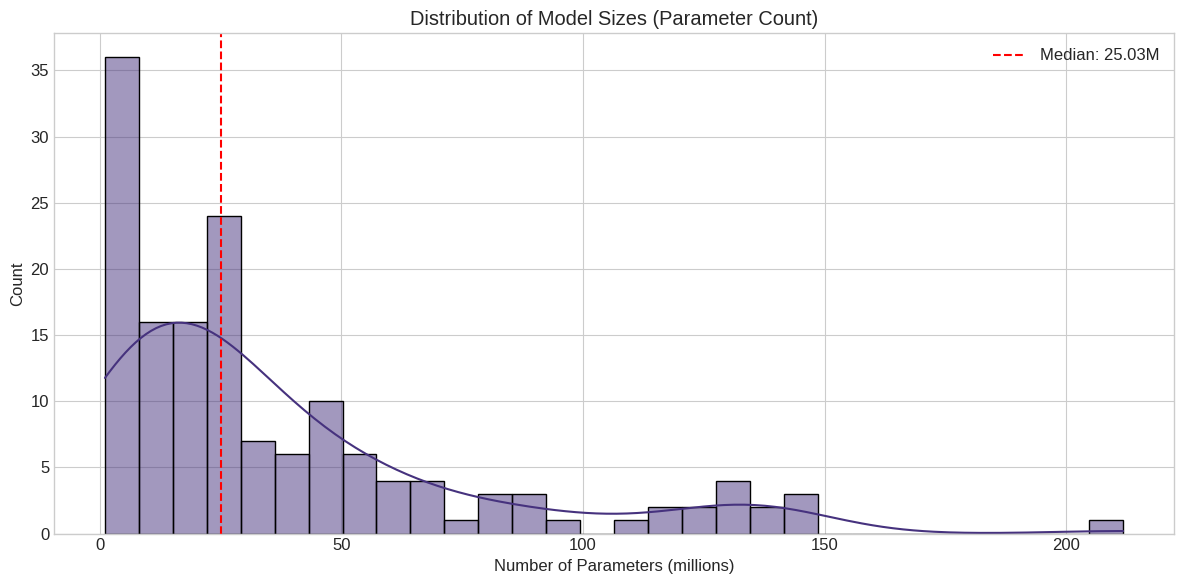

In [10]:
# Analyze the distribution of parameter counts
plt.figure(figsize=(12, 6))

# Use the numeric parameter count column
sns.histplot(benchmark_224["param_count_numeric"], bins=30, kde=True)
plt.title('Distribution of Model Sizes (Parameter Count)')
plt.xlabel('Number of Parameters (millions)')
plt.ylabel('Count')

# Add median line
median_params = benchmark_224["param_count_numeric"].median()
plt.axvline(x=median_params, color='red', linestyle='--',
            label=f'Median: {median_params:.2f}M')
plt.legend()
plt.tight_layout()
plt.show()

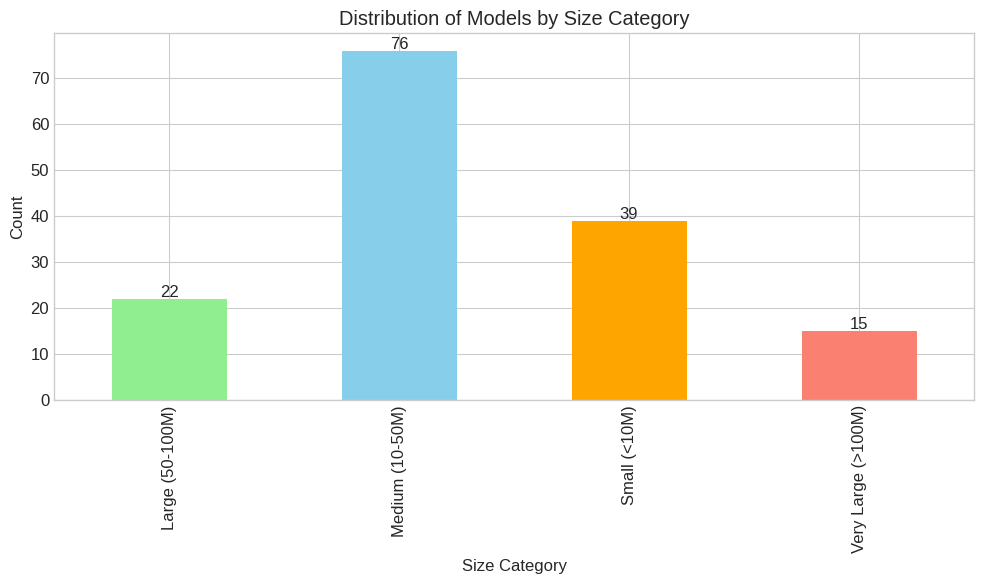

In [11]:
# Group models by size categories
def categorize_model_size(param_count):
    if param_count < 10:
        return "Small (<10M)"
    elif param_count < 50:
        return "Medium (10-50M)"
    elif param_count < 100:
        return "Large (50-100M)"
    else:
        return "Very Large (>100M)"

benchmark_224["size_category"] = benchmark_224["param_count_numeric"].apply(categorize_model_size)

# Plot size categories distribution
plt.figure(figsize=(10, 6))
size_dist = benchmark_224["size_category"].value_counts().sort_index()
ax = size_dist.plot(kind='bar', color=['lightgreen', 'skyblue', 'orange', 'salmon'])
plt.title('Distribution of Models by Size Category')
plt.xlabel('Size Category')
plt.ylabel('Count')

# Add count labels
for i, v in enumerate(size_dist):
    ax.text(i, v + 0.5, str(v), ha='center')

plt.tight_layout()
plt.show()

## Section 5: Analyze Top-1 and Top-5 Accuracy Distribution

Now let's analyze the accuracy metrics across the models.

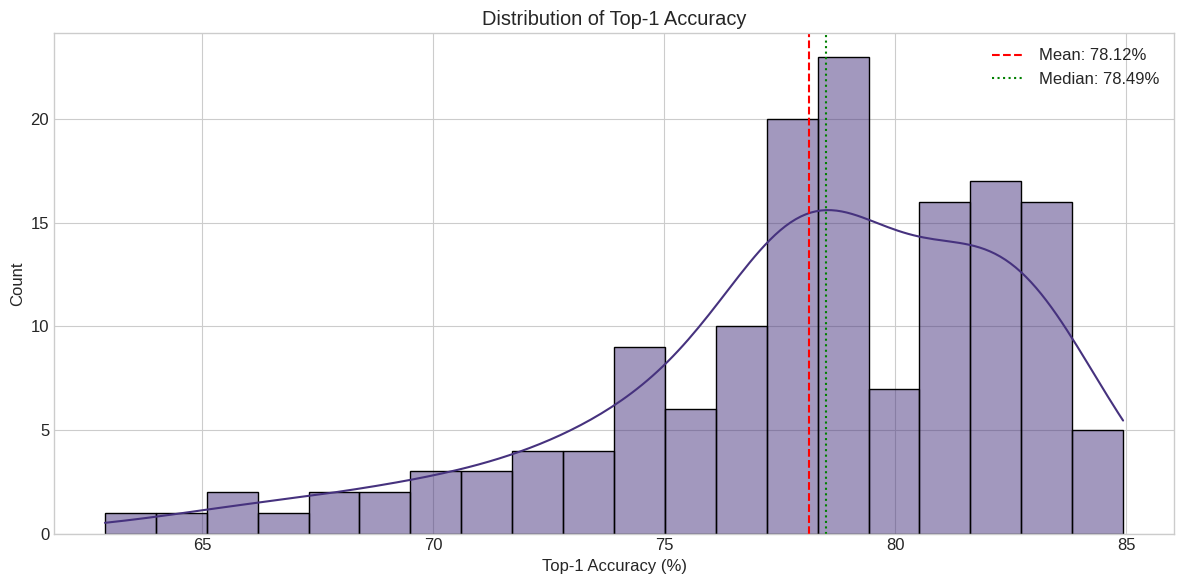

In [12]:
# Analyze distribution of Top-1 accuracy
plt.figure(figsize=(12, 6))
sns.histplot(benchmark_224["top1"], bins=20, kde=True)
plt.title('Distribution of Top-1 Accuracy')
plt.xlabel('Top-1 Accuracy (%)')
plt.ylabel('Count')

# Add mean and median lines
mean_top1 = benchmark_224["top1"].mean()
median_top1 = benchmark_224["top1"].median()
plt.axvline(x=mean_top1, color='red', linestyle='--',
            label=f'Mean: {mean_top1:.2f}%')
plt.axvline(x=median_top1, color='green', linestyle=':',
            label=f'Median: {median_top1:.2f}%')
plt.legend()
plt.tight_layout()
plt.show()

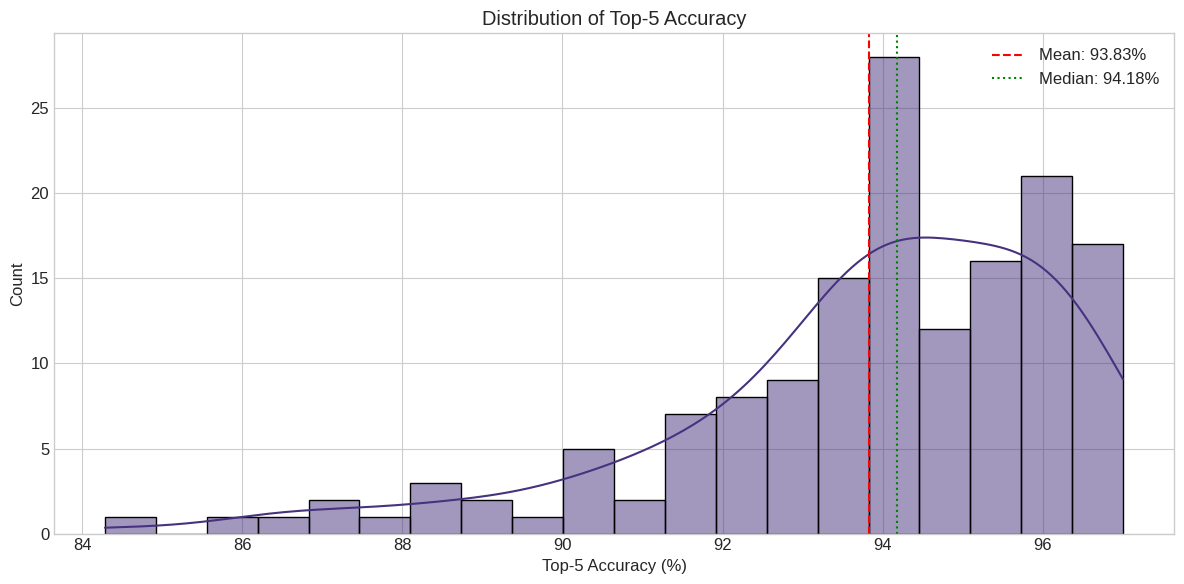

In [13]:
# Analyze distribution of Top-5 accuracy
plt.figure(figsize=(12, 6))
sns.histplot(benchmark_224["top5"], bins=20, kde=True)
plt.title('Distribution of Top-5 Accuracy')
plt.xlabel('Top-5 Accuracy (%)')
plt.ylabel('Count')

# Add mean and median lines
mean_top5 = benchmark_224["top5"].mean()
median_top5 = benchmark_224["top5"].median()
plt.axvline(x=mean_top5, color='red', linestyle='--',
            label=f'Mean: {mean_top5:.2f}%')
plt.axvline(x=median_top5, color='green', linestyle=':',
            label=f'Median: {median_top5:.2f}%')
plt.legend()
plt.tight_layout()
plt.show()

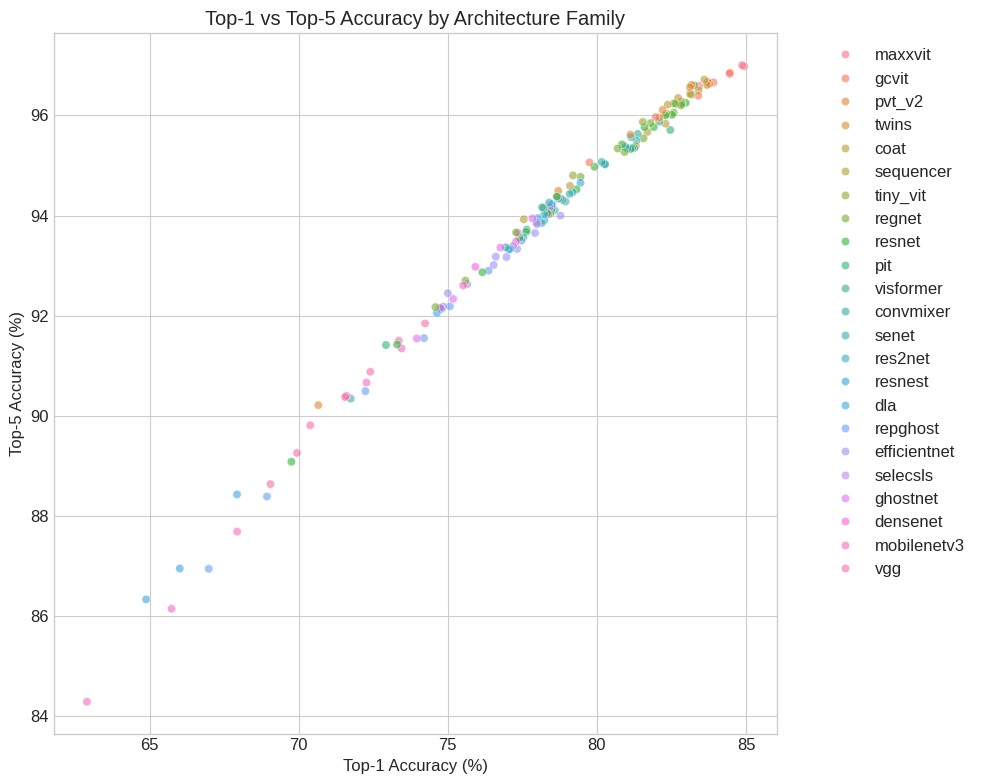

In [14]:
# Relationship between Top-1 and Top-5 accuracy
plt.figure(figsize=(10, 8))
sns.scatterplot(x="top1", y="top5", data=benchmark_224, alpha=0.6, hue="module")
plt.title('Top-1 vs Top-5 Accuracy by Architecture Family')
plt.xlabel('Top-1 Accuracy (%)')
plt.ylabel('Top-5 Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Section 6: Compare Accuracy vs. Model Size

Let's analyze the relationship between model accuracy and parameter count to find efficient models.

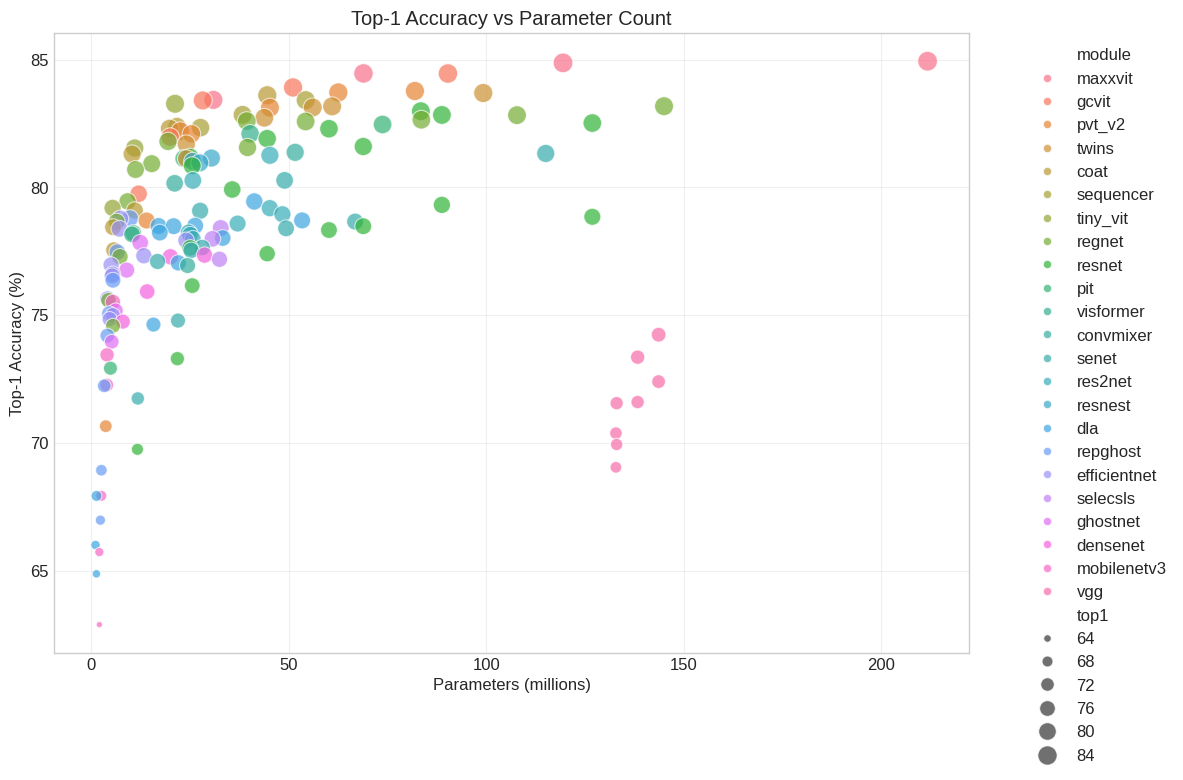

In [15]:
# Plot Top-1 accuracy vs parameter count
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x="param_count_numeric", y="top1",
                        hue="module", size="top1",
                        sizes=(20, 200), alpha=0.7,
                        data=benchmark_224)
plt.title('Top-1 Accuracy vs Parameter Count')
plt.xlabel('Parameters (millions)')
plt.ylabel('Top-1 Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

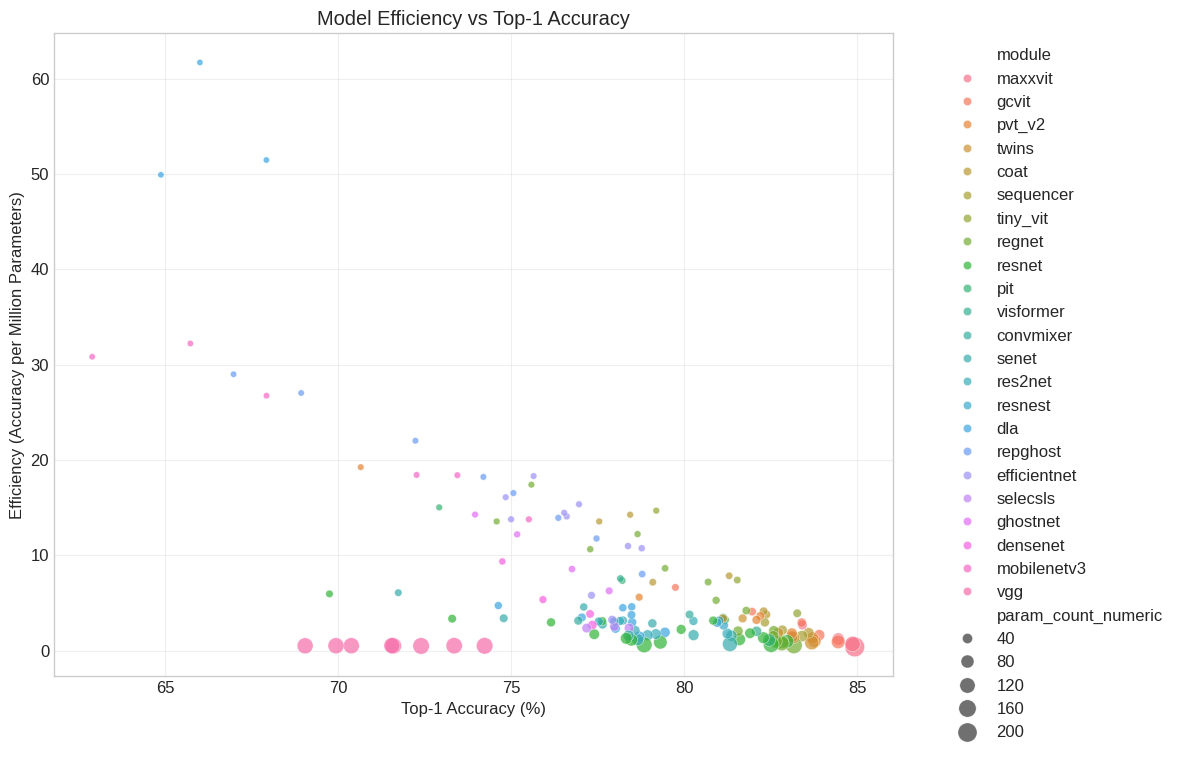

In [16]:
# Calculate efficiency metric (accuracy per parameter)
benchmark_224["efficiency"] = benchmark_224["top1"] / benchmark_224["param_count_numeric"]

# Plot efficiency vs accuracy
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x="top1", y="efficiency",
                         hue="module", size="param_count_numeric",
                         sizes=(20, 200), alpha=0.7,
                         data=benchmark_224)
plt.title('Model Efficiency vs Top-1 Accuracy')
plt.xlabel('Top-1 Accuracy (%)')
plt.ylabel('Efficiency (Accuracy per Million Parameters)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Section 7: Identify Top Models by Accuracy and Size

Let's find the most promising models based on accuracy and efficiency metrics.

In [17]:
# Get the top 15 most accurate models
top_accuracy_models = benchmark_224.sort_values('top1', ascending=False).head(15)
print("Top 15 Models by Top-1 Accuracy:")
top_accuracy_models[['model', 'module', 'top1', 'top5', 'param_count_numeric']].reset_index(drop=True)

Top 15 Models by Top-1 Accuracy:


,model,module,top1,top5,param_count_numeric
0,maxvit_large_tf_224.in1k,maxxvit,84.934,96.980,211.79
1,maxvit_base_tf_224.in1k,maxxvit,84.870,97.004,119.47
2,maxvit_small_tf_224.in1k,maxxvit,84.456,96.828,68.93
3,gcvit_base.in1k,gcvit,84.454,96.850,90.32
4,gcvit_small.in1k,gcvit,83.908,96.660,51.09
5,pvt_v2_b5.in1k,pvt_v2,83.768,96.632,81.96
6,pvt_v2_b4.in1k,pvt_v2,83.712,96.670,62.56
7,twins_svt_large.in1k,twins,83.690,96.608,99.27
8,coat_lite_medium.in1k,coat,83.602,96.714,44.57
9,maxvit_tiny_tf_224.in1k,maxxvit,83.422,96.590,30.92


In [18]:
# Get the top 15 most efficient models (with at least 75% top-1 accuracy)
efficient_models = benchmark_224[benchmark_224['top1'] >= 75].sort_values('efficiency', ascending=False).head(15)
print("Top 15 Models by Efficiency (with 75%+ Top-1 Accuracy):")
efficient_models[['model', 'module', 'top1', 'param_count_numeric', 'efficiency']].reset_index(drop=True)

Top 15 Models by Efficiency (with 75%+ Top-1 Accuracy):


,model,module,top1,param_count_numeric,efficiency
0,tf_mixnet_s.in1k,efficientnet,75.652,4.13,18.317676
1,regnety_004.tv2_in1k,regnet,75.588,4.34,17.416590
2,repghostnet_111.in1k,repghost,75.068,4.54,16.534802
3,tf_mixnet_m.in1k,efficientnet,76.964,5.01,15.362076
4,tiny_vit_5m_224.in1k,tiny_vit,79.196,5.39,14.693135
5,tf_efficientnet_b0.in1k,efficientnet,76.536,5.29,14.468053
6,coat_tiny.in1k,coat,78.442,5.50,14.262182
7,tf_efficientnet_es.in1k,efficientnet,76.608,5.44,14.082353
8,repghostnet_130.in1k,repghost,76.366,5.48,13.935401
9,efficientnet_es_pruned.in1k,efficientnet,75.000,5.44,13.786765


In [19]:
# Get the top models with less than 30M parameters and at least 78% top-1 accuracy
compact_models = benchmark_224[(benchmark_224['param_count_numeric'] < 30) &
                             (benchmark_224['top1'] >= 78)].sort_values('top1', ascending=False)
print("Top Compact Models (<30M params, 78%+ accuracy):")
compact_models[['model', 'module', 'top1', 'param_count_numeric', 'efficiency']].reset_index(drop=True)

Top Compact Models (<30M params, 78%+ accuracy):


,model,module,top1,param_count_numeric,efficiency
0,gcvit_tiny.in1k,gcvit,83.400,28.22,2.955351
1,tiny_vit_21m_224.in1k,tiny_vit,83.270,21.20,3.927830
2,coat_small.in1k,coat,82.376,21.69,3.797879
3,sequencer2d_s.in1k,sequencer,82.336,27.65,2.977794
4,coat_lite_small.in1k,coat,82.302,19.84,4.148286
5,pvt_v2_b2_li.in1k,pvt_v2,82.202,22.55,3.645322
6,pvt_v2_b2.in1k,pvt_v2,82.094,25.36,3.237145
7,gcvit_xtiny.in1k,gcvit,81.968,19.98,4.102503
8,regnety_032.tv2_in1k,regnet,81.798,19.44,4.207716
9,twins_svt_small.in1k,twins,81.692,24.06,3.395345


## Section 8: Tabulate Best Models per Architecture

Let's identify the best model from each architecture family to ensure we have diverse options.

In [20]:
# Select the highest top-1 accuracy model from each module family
best_per_family = benchmark_224.sort_values('top1', ascending=False).drop_duplicates('module').reset_index(drop=True)
best_per_family = best_per_family.sort_values('top1', ascending=False)

print(f"Best model from each of the {len(best_per_family)} architecture families:")
best_per_family[['module', 'model', 'top1', 'top5', 'param_count_numeric', 'img_size']].head(20)

Best model from each of the 23 architecture families:


,module,model,top1,top5,param_count_numeric,img_size
0,maxxvit,maxvit_large_tf_224.in1k,84.934,96.980,211.79,224
1,gcvit,gcvit_base.in1k,84.454,96.850,90.32,224
2,pvt_v2,pvt_v2_b5.in1k,83.768,96.632,81.96,224
3,twins,twins_svt_large.in1k,83.690,96.608,99.27,224
4,coat,coat_lite_medium.in1k,83.602,96.714,44.57,224
5,sequencer,sequencer2d_l.in1k,83.410,96.504,54.30,224
6,tiny_vit,tiny_vit_21m_224.in1k,83.270,96.602,21.20,224
7,regnet,regnety_320.tv2_in1k,83.174,96.416,145.05,224
8,resnet,resnext101_64x4d.tv_in1k,82.978,96.252,83.46,224
9,pit,pit_b_224.in1k,82.460,95.708,73.76,224


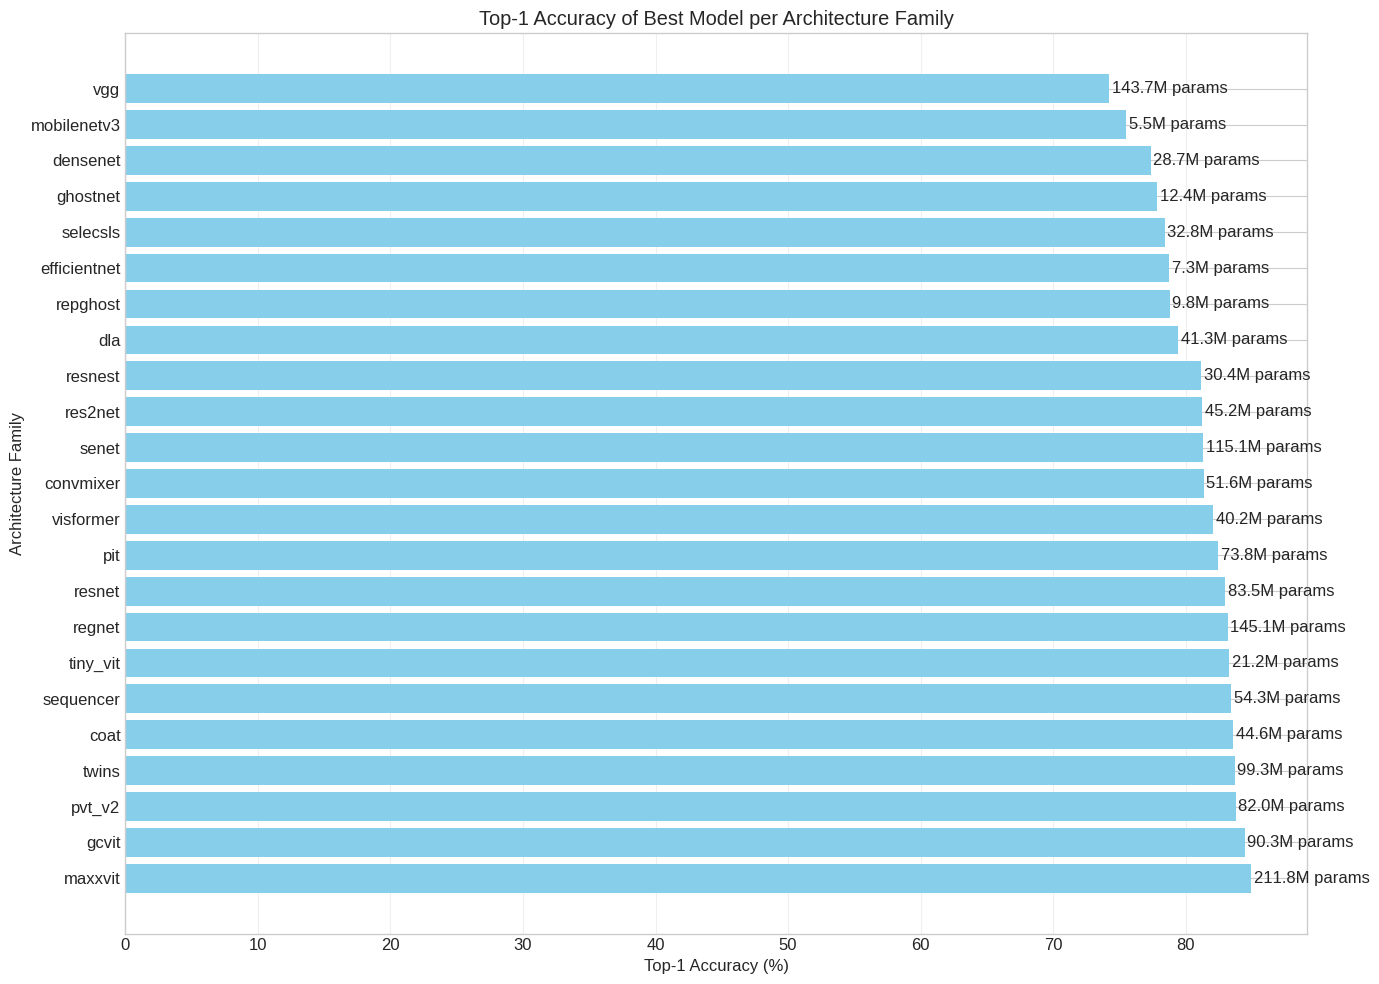

In [21]:
# Create a visual comparison of the best models per family
plt.figure(figsize=(14, 10))
bars = plt.barh(best_per_family['module'], best_per_family['top1'], color='skyblue')
plt.title('Top-1 Accuracy of Best Model per Architecture Family')
plt.xlabel('Top-1 Accuracy (%)')
plt.ylabel('Architecture Family')
plt.grid(axis='x', alpha=0.3)

# Add parameter count as text
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.2,
             bar.get_y() + bar.get_height()/2,
             f"{best_per_family['param_count_numeric'].iloc[i]:.1f}M params",
             va='center')

plt.tight_layout()
plt.show()

## Section 9: Visualize Model Family Performance

Let's visualize performance trends across model families and create comparative visualizations.

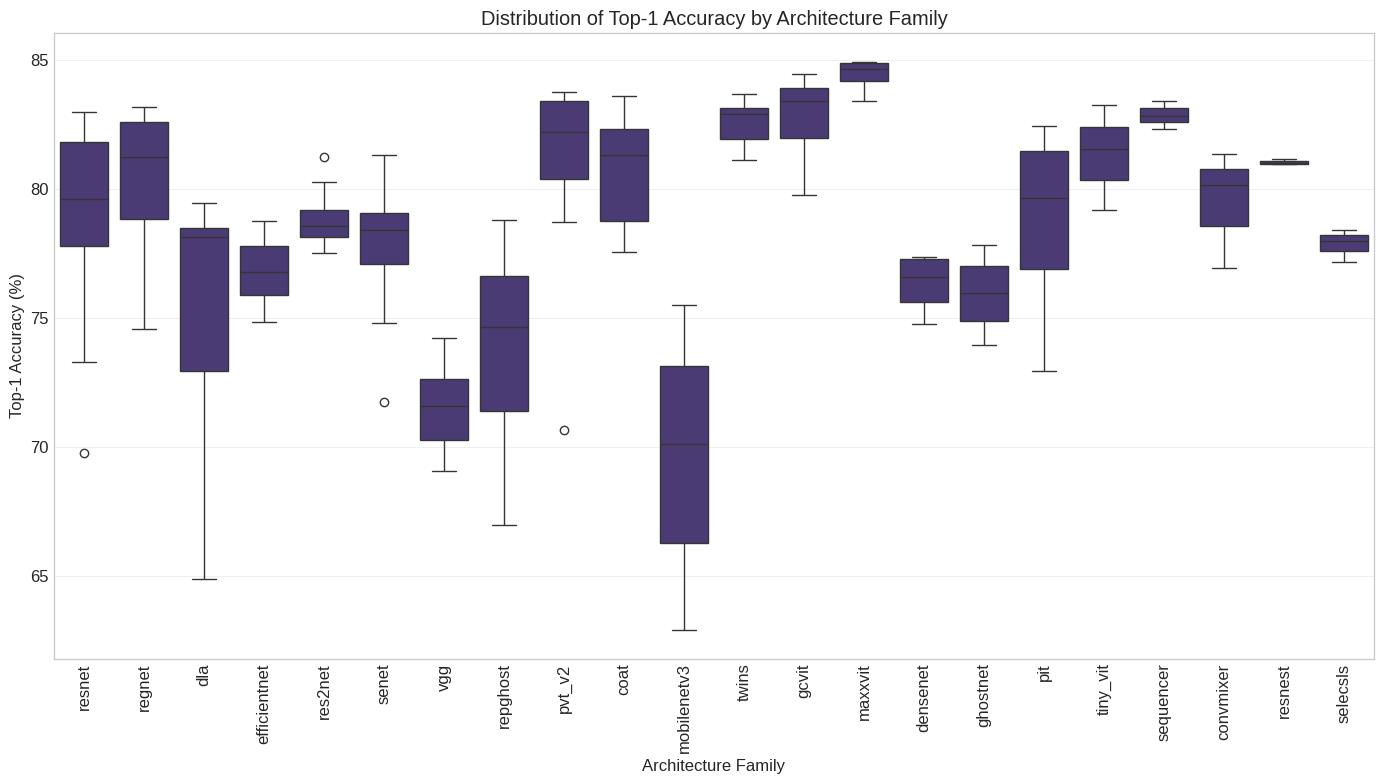

In [22]:
# Boxplot of Top-1 accuracy by module family for families with at least 3 models
module_counts = benchmark_224['module'].value_counts()
modules_with_enough_models = module_counts[module_counts >= 3].index.tolist()

plt.figure(figsize=(14, 8))
benchmark_filtered = benchmark_224[benchmark_224['module'].isin(modules_with_enough_models)]
sns.boxplot(x='module', y='top1', data=benchmark_filtered, order=modules_with_enough_models)
plt.title('Distribution of Top-1 Accuracy by Architecture Family')
plt.xlabel('Architecture Family')
plt.ylabel('Top-1 Accuracy (%)')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

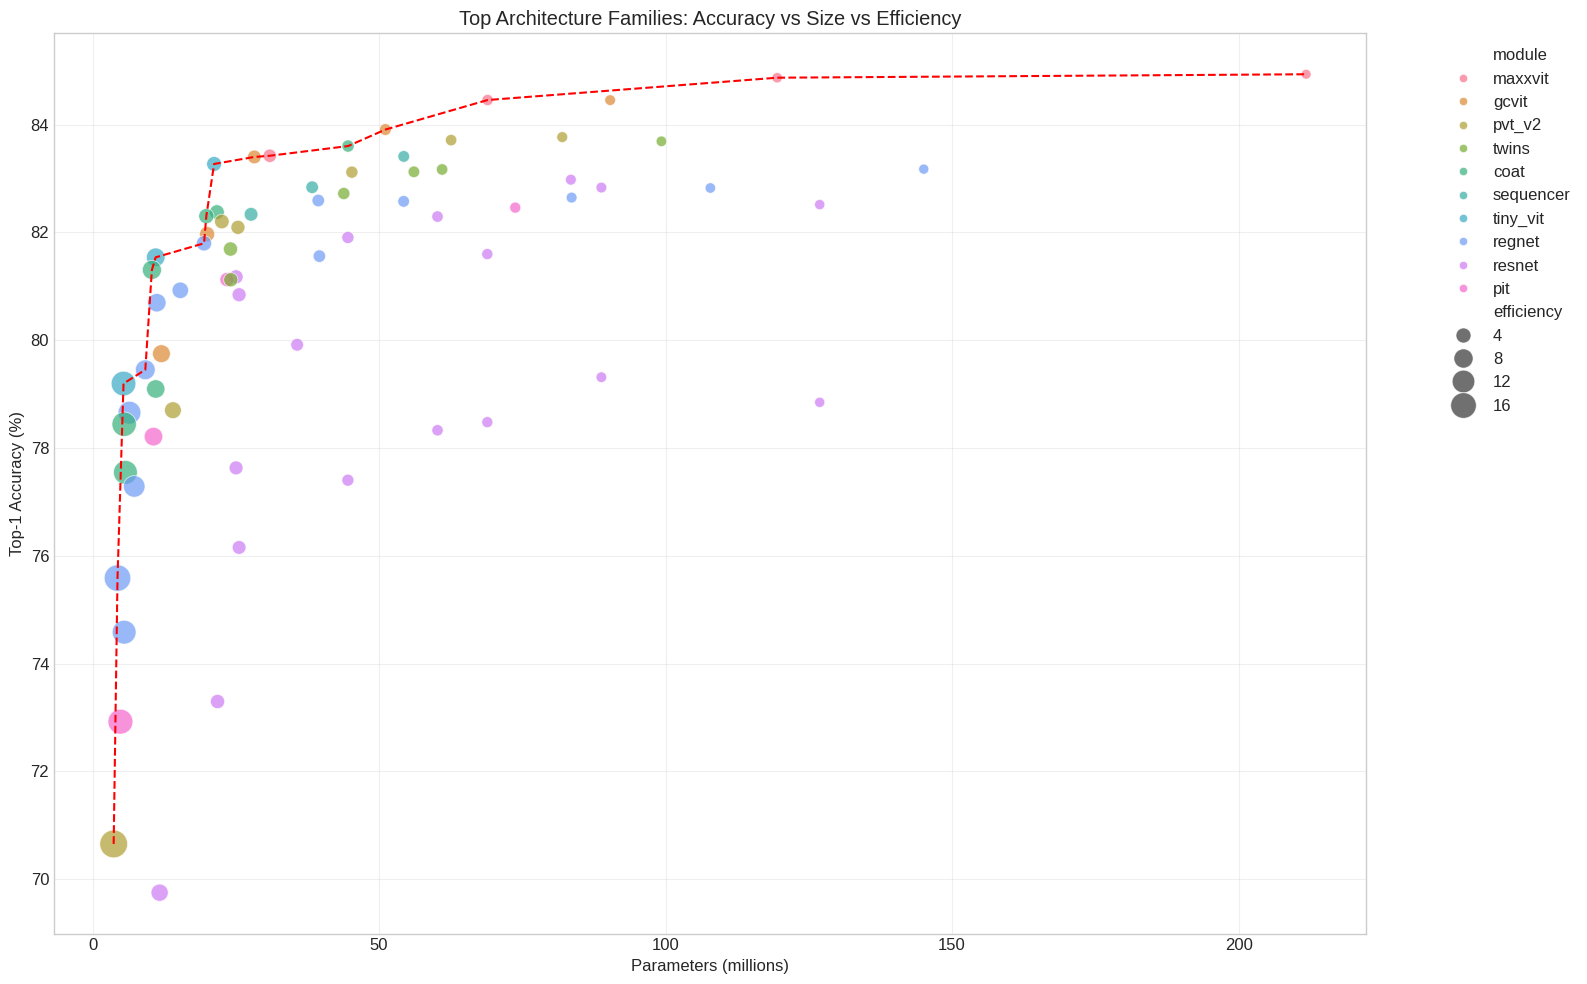

In [23]:
# Create a scatter plot with parameter count vs top-1 accuracy, with points colored by module
# and sized by efficiency
plt.figure(figsize=(16, 10))

# Select top 10 module families by max top-1 accuracy for clarity
top_modules = module_max_top1.head(10).index.tolist()
plot_data = benchmark_224[benchmark_224['module'].isin(top_modules)]

# Create the scatter plot
scatter = sns.scatterplot(x='param_count_numeric', y='top1',
                         hue='module', size='efficiency',
                         sizes=(50, 400), alpha=0.7,
                         data=plot_data)

plt.title('Top Architecture Families: Accuracy vs Size vs Efficiency')
plt.xlabel('Parameters (millions)')
plt.ylabel('Top-1 Accuracy (%)')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a Pareto frontier line connecting the most efficient models
pareto = []
data = plot_data.sort_values('param_count_numeric')
max_top1 = 0
for _, row in data.iterrows():
    if row['top1'] > max_top1:
        max_top1 = row['top1']
        pareto.append((row['param_count_numeric'], row['top1']))

pareto_x, pareto_y = zip(*pareto)
plt.plot(pareto_x, pareto_y, 'r--', label='Pareto Frontier')

plt.tight_layout()
plt.show()

## Section 10: Export Selected Backbone Candidates

Based on our analysis, let's select and export candidate backbone models for our image similarity assessment models.

In [24]:
# Define criteria for selecting backbone candidates
# 1. High accuracy models (top performers)
# 2. Efficient models (good accuracy/parameter ratio)
# 3. Compact models (<30M params with good accuracy)
# 4. Diverse architecture representation

# Combine the best candidates from different criteria
high_accuracy_candidates = top_accuracy_models.head(5)[['model', 'module', 'top1', 'param_count_numeric']]
high_accuracy_candidates['selection_criteria'] = 'Top Accuracy'

efficient_candidates = efficient_models.head(5)[['model', 'module', 'top1', 'param_count_numeric']]
efficient_candidates['selection_criteria'] = 'High Efficiency'

compact_candidates = compact_models.head(5)[['model', 'module', 'top1', 'param_count_numeric']]
compact_candidates['selection_criteria'] = 'Compact Size'

# Combine all candidates
all_candidates = pd.concat([high_accuracy_candidates, efficient_candidates, compact_candidates])

# Remove duplicates if a model appears in multiple categories
final_candidates = all_candidates.drop_duplicates('model').reset_index(drop=True)

print(f"Selected {len(final_candidates)} backbone candidates for image similarity assessment models:")
final_candidates

Selected 15 backbone candidates for image similarity assessment models:


,model,module,top1,param_count_numeric,selection_criteria
0,maxvit_large_tf_224.in1k,maxxvit,84.934,211.79,Top Accuracy
1,maxvit_base_tf_224.in1k,maxxvit,84.870,119.47,Top Accuracy
2,maxvit_small_tf_224.in1k,maxxvit,84.456,68.93,Top Accuracy
3,gcvit_base.in1k,gcvit,84.454,90.32,Top Accuracy
4,gcvit_small.in1k,gcvit,83.908,51.09,Top Accuracy
5,tf_mixnet_s.in1k,efficientnet,75.652,4.13,High Efficiency
6,regnety_004.tv2_in1k,regnet,75.588,4.34,High Efficiency
7,repghostnet_111.in1k,repghost,75.068,4.54,High Efficiency
8,tf_mixnet_m.in1k,efficientnet,76.964,5.01,High Efficiency
9,tiny_vit_5m_224.in1k,tiny_vit,79.196,5.39,High Efficiency


In [25]:
# Export the candidate list to CSV for use in next notebooks
final_candidates.to_csv('backbone_candidates.csv', index=False)

# Save a more detailed version with additional metrics
detailed_candidates = benchmark_224[benchmark_224['model'].isin(final_candidates['model'])]
detailed_candidates = detailed_candidates.merge(final_candidates[['model', 'selection_criteria']], on='model')
detailed_candidates.to_csv('backbone_candidates_detailed.csv', index=False)

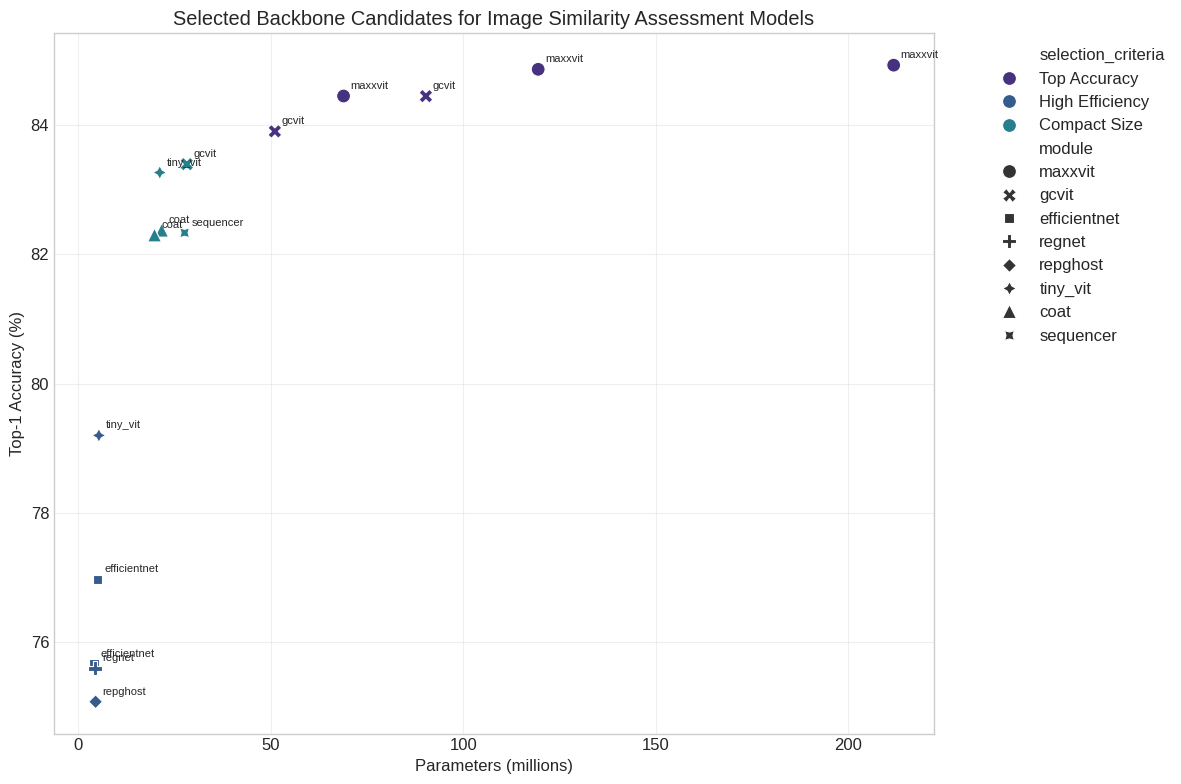

In [26]:
# Visualize our final candidates
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x='param_count_numeric', y='top1',
                        hue='selection_criteria', style='module',
                        s=100, data=final_candidates)

plt.title('Selected Backbone Candidates for Image Similarity Assessment Models')
plt.xlabel('Parameters (millions)')
plt.ylabel('Top-1 Accuracy (%)')
plt.grid(True, alpha=0.3)

# Add model names as annotations
for i, row in final_candidates.iterrows():
    plt.annotate(row['module'],
                 (row['param_count_numeric'], row['top1']),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=8)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Summary and Conclusions

In this notebook, we performed a comprehensive analysis of available pretrained models in the `timm` library to select suitable backbones for our image similarity assessment models on the flower similarity task.

Key findings:

1. **Architecture Diversity**: We evaluated models across multiple architecture families, including ConvNeXt, EfficientNet, ResNet variants, Vision Transformers, and more.

2. **Size-Accuracy Trade-off**: We identified a clear relationship between model size and accuracy, with certain architecture families providing better efficiency.

3. **Selection Criteria**: We selected backbone candidates based on three criteria:
   - Top accuracy performers
   - High efficiency models (accuracy per parameter)
   - Compact yet accurate models

4. **Export Results**: We exported our final candidate list for use in the next notebook, where we'll implement these backbones in our models.

In the next notebook, we'll use these selected backbone models to build and train our models for flower image similarity assessment.